<a href="https://colab.research.google.com/github/AkhilVinayakp/HAR_LSTM_CNN/blob/main/lstm_cnn_model_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%cd /content/drive/My\ Drive/datasets 
%pwd

/content/drive/My Drive/datasets


'/content/drive/My Drive/datasets'

In [3]:

df =  pd.read_csv('int_norm.csv')

In [4]:
df.shape

(1098204, 6)

In [5]:
def create_windowed_dataset(series, window_size,shift_size, batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size , shift = shift_size, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.map(lambda window: ( window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6) ))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
df.drop('timestamp', axis = 1, inplace=True)

In [7]:
df.activity = df.activity.astype('category').cat.codes
df.activity = df.activity.astype('int64')

In [8]:
train = df[df['user'] < 31 ]
test = df[df['user'] > 30]

In [9]:
train.drop('user', axis = 1, inplace=True)
test.drop('user', axis = 1, inplace=True)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
print(train.shape)
print(test.shape)

(898361, 4)
(199843, 4)


In [11]:
train.head()

,activity,x-axis,y-axis,z-axis
0,5,0.058149,0.996847,-0.053996
1,5,-0.000000,0.998427,-0.056061
2,5,-0.023448,0.997247,-0.070345
3,5,0.014845,0.998642,-0.049932
4,5,0.014737,0.998072,-0.060286


In [12]:
test.head()

,activity,x-axis,y-axis,z-axis
0,1,-0.054655,0.997718,0.039652
1,1,0.405338,0.910910,0.077102
2,1,0.410782,0.911708,-0.006846
3,1,-0.032685,0.986373,0.161248
4,1,-0.083804,0.856341,0.509566


In [13]:
# creating test set
def create_test_windowed(series, window_size = 128):
  test = tf.data.Dataset.from_tensor_slices(series)
  test = test.window(window_size, drop_remainder = True)
  test = test.flat_map(lambda window: window.batch(window_size))
  test = test.map(lambda window: (window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6)))
  return test

In [14]:
test_win = create_test_windowed(test)   # test data set for evaluation

In [15]:
test_data = list(test_win.as_numpy_iterator())

In [16]:
test_f = []
test_l = []
for i in test_data:
  test_f.append(i[0])
  test_l.append(i[1])

In [17]:
test_f = np.array(test_f)

In [18]:
test_f.shape

(1561, 128, 3)

In [19]:
test_l = np.array(test_l)

In [20]:
test_l.shape

(1561, 6)

In [21]:
x_val = test_f[:200]
y_val = test_l[:200]
print(x_val.shape)
print(y_val.shape)

(200, 128, 3)
(200, 6)


In [22]:
train_windowed = create_windowed_dataset(train, 128, 64, 192, 128)

In [23]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Conv2D(64,5,strides=(2,2)),
  tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  
  tf.keras.layers.Conv2D(128,3,strides=(1,1)),  
  tf.keras.layers.GlobalAveragePooling2D(),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 3)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 32)           8320      
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 32, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 14, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 7, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 5, 128)        7

In [25]:
# designing class back to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
save = ModelCheckpoint('best_trained_model.h5', save_best_only = True)

In [26]:

train = train_windowed.take(round(13654*0.7))
val = train_windowed.skip(round(13654*0.7))

In [27]:
# with out bidirection
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model.fit(train_windowed, validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192)

Epoch 1/200
74/74 [==============================] - 40s 66ms/step - loss: 1.3404 - accuracy: 0.6017 - val_loss: 1.6423 - val_accuracy: 0.3555
Epoch 2/200
74/74 [==============================] - 4s 52ms/step - loss: 0.9550 - accuracy: 0.7241 - val_loss: 1.6089 - val_accuracy: 0.3555
Epoch 3/200
74/74 [==============================] - 4s 52ms/step - loss: 0.8986 - accuracy: 0.7549 - val_loss: 1.6497 - val_accuracy: 0.3555
Epoch 4/200
74/74 [==============================] - 4s 54ms/step - loss: 0.8635 - accuracy: 0.7539 - val_loss: 1.6031 - val_accuracy: 0.3555
Epoch 5/200
74/74 [==============================] - 4s 52ms/step - loss: 0.8569 - accuracy: 0.7422 - val_loss: 1.4786 - val_accuracy: 0.3863
Epoch 6/200
74/74 [==============================] - 4s 52ms/step - loss: 0.8474 - accuracy: 0.7334 - val_loss: 1.4301 - val_accuracy: 0.4331
Epoch 7/200
74/74 [==============================] - 4s 53ms/step - loss: 0.8188 - accuracy: 0.7463 - val_loss: 1.3566 - val_accuracy: 0.5753
Epoch

In [ ]:
# model.save('prime_model.h5')

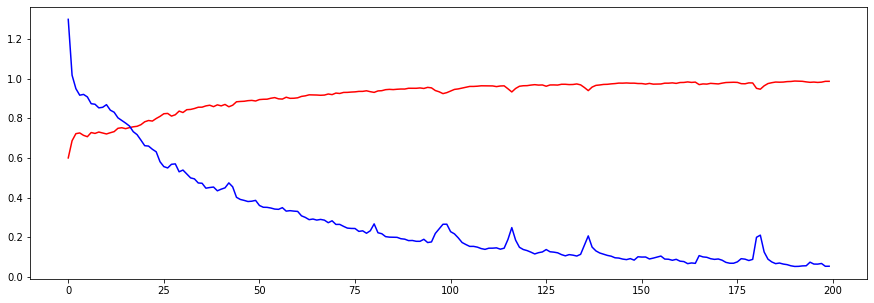

In [28]:
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['loss'], color = 'b')

No handles with labels found to put in legend.


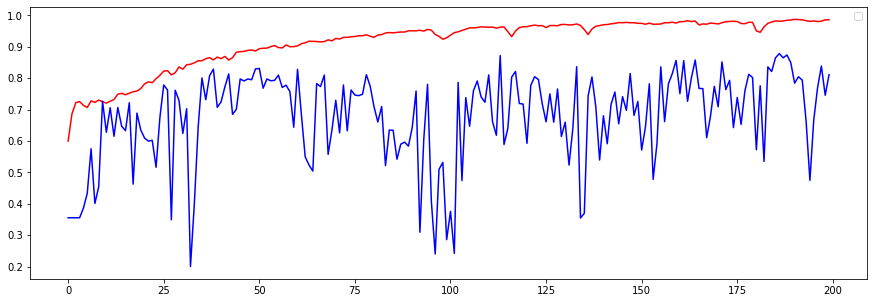

In [35]:
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()

In [30]:
eval = model.evaluate(test_f,test_l)

49/49 [==============================] - 0s 8ms/step - loss: 0.6752 - accuracy: 0.8110


In [33]:
b_model = tf.keras.models.load_model('best_trained_model.h5')

In [34]:
b_model.evaluate(test_f, test_l)

49/49 [==============================] - 1s 8ms/step - loss: 0.4179 - accuracy: 0.8783


[0.41786670684814453, 0.8782831430435181]

In [36]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model_bi_dir = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Conv2D(64,5,strides=(2,2)),
  tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  
  tf.keras.layers.Conv2D(128,3,strides=(1,1)),  
  tf.keras.layers.GlobalAveragePooling2D(),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [39]:
model_bi_dir.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 128, 3)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 64)           9216      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 64)           24832     
_________________________________________________________________
lambda_3 (Lambda)            (None, 128, 64, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 30, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 13, 128)      

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
save_bi = ModelCheckpoint('best_trained_model_bi.h5', save_best_only = True)

In [42]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_bi_dir.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model_bi_dir.fit(train_windowed, validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192)

Epoch 1/200
74/74 [==============================] - 11s 82ms/step - loss: 1.4130 - accuracy: 0.5878 - val_loss: 1.6151 - val_accuracy: 0.3555
Epoch 2/200
74/74 [==============================] - 5s 64ms/step - loss: 0.9919 - accuracy: 0.7295 - val_loss: 1.5585 - val_accuracy: 0.3555
Epoch 3/200
74/74 [==============================] - 5s 65ms/step - loss: 0.9159 - accuracy: 0.7398 - val_loss: 1.5424 - val_accuracy: 0.3555
Epoch 4/200
74/74 [==============================] - 5s 65ms/step - loss: 0.8870 - accuracy: 0.7428 - val_loss: 1.5253 - val_accuracy: 0.3568
Epoch 5/200
74/74 [==============================] - 5s 65ms/step - loss: 0.8563 - accuracy: 0.7465 - val_loss: 1.5405 - val_accuracy: 0.3581
Epoch 6/200
74/74 [==============================] - 5s 65ms/step - loss: 0.8053 - accuracy: 0.7520 - val_loss: 2.1952 - val_accuracy: 0.3857
Epoch 7/200
74/74 [==============================] - 5s 66ms/step - loss: 0.8073 - accuracy: 0.7559 - val_loss: 1.3069 - val_accuracy: 0.6400
Epoch

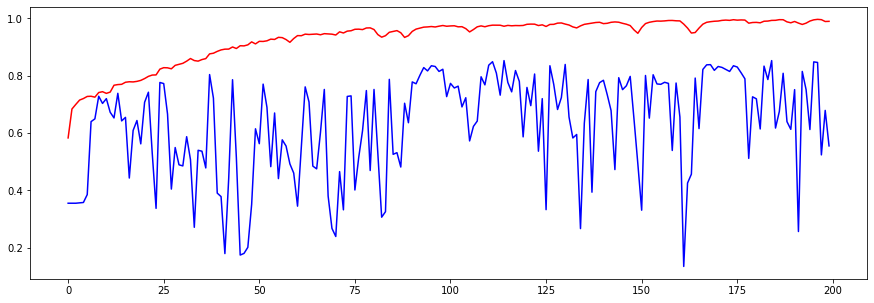

In [43]:
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()